
# Vision Transformer Classification on Oily, Dry, and Normal Skin Dataset  



## Abstract  
This notebook performs a comparative experiment of multiple Vision Transformer-based architectures using the dataset **Oily, Dry and Normal Skin Types Dataset** from Kaggle.  
The experiment includes:
- Data preprocessing  
- Training two models (ViT and Swin Transformer)  
- Evaluation using accuracy, F1-score, and confusion matrix  
- Inference speed measurement  
- Saving model results  


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os, shutil, zipfile, glob
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import platform

!pip install timm -q
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Mounted at /content/drive
Using: cuda


### 1. Inisialisasi dan Impor Pustaka

Sel ini melakukan beberapa hal penting:
1.  **Menghubungkan Google Drive**: `drive.mount` digunakan untuk mengakses file dari Google Drive, terutama untuk menyimpan model yang telah dilatih dan mengambil kredensial Kaggle.
2.  **Impor Pustaka Utama**: Mengimpor pustaka-pustaka penting seperti `os`, `numpy`, `torch`, `torchvision`, dan `sklearn` yang akan digunakan di seluruh notebook.
3.  **Instalasi `timm`**: Pustaka `timm` (PyTorch Image Models) diinstal karena menyediakan implementasi model Vision Transformer (ViT) dan Swin Transformer yang siap pakai.
4.  **Pengaturan Device**: Kode ini memeriksa apakah GPU (CUDA) tersedia. Jika ya, semua operasi PyTorch akan dijalankan di GPU untuk mempercepat pelatihan. Jika tidak, akan menggunakan CPU.

In [3]:

# Setup Kaggle API
kaggle_json_path = "/content/drive/MyDrive/kaggle/kaggle.json"

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy(kaggle_json_path, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

!kaggle --version


Kaggle API 1.7.4.5


### 2. Pengaturan API Kaggle

Untuk mengunduh dataset langsung dari Kaggle, kita perlu melakukan otentikasi menggunakan token API Kaggle.
1.  **Menentukan Lokasi `kaggle.json`**: Path ke file `kaggle.json` yang disimpan di Google Drive ditentukan.
2.  **Menyalin File Konfigurasi**: File `kaggle.json` disalin ke direktori `~/.kaggle/` yang merupakan lokasi standar yang dicari oleh Kaggle CLI.
3.  **Mengatur Izin Akses**: Izin file diubah menjadi `600` (hanya pemilik yang dapat membaca dan menulis) untuk menjaga keamanan token API.
4.  **Verifikasi**: Perintah `!kaggle --version` dijalankan untuk memastikan bahwa Kaggle CLI telah terkonfigurasi dengan benar.

In [4]:

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset -p /content/data

zip_path = glob.glob(os.path.join(DATA_DIR, "*.zip"))[0]
print("ZIP FOUND:", zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

!ls /content/data


Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): apache-2.0
 72% 89.0M/124M [00:00<00:00, 931MB/s]
100% 124M/124M [00:00<00:00, 593MB/s] 
ZIP FOUND: /content/data/oily-dry-and-normal-skin-types-dataset.zip
oily-dry-and-normal-skin-types-dataset.zip  Oily-Dry-Skin-Types


### 3. Mengunduh dan Mengekstrak Dataset

Setelah API Kaggle siap, langkah selanjutnya adalah mengunduh dan menyiapkan dataset.
1.  **Membuat Direktori Data**: Direktori `/content/data` dibuat untuk menyimpan file dataset.
2.  **Mengunduh Dataset**: Perintah `!kaggle datasets download` digunakan untuk mengunduh dataset "Oily, Dry and Normal Skin Types" dari Kaggle. File diunduh dalam format ZIP.
3.  **Mengekstrak File ZIP**: Kode ini mencari file ZIP yang baru diunduh, lalu mengekstrak seluruh isinya ke direktori `/content/data`.
4.  **Memeriksa Isi**: Perintah `!ls` digunakan untuk melihat isi direktori dan memastikan dataset telah diekstrak dengan benar.

In [5]:

root = "/content/data/Oily-Dry-Skin-Types"

IMG_SIZE = 224
BATCH_SIZE = 32

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder(root + "/train", transform=train_tf)
val_ds   = datasets.ImageFolder(root + "/valid", transform=test_tf)
test_ds  = datasets.ImageFolder(root + "/test",  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print("Classes:", train_ds.classes)
num_classes = len(train_ds.classes)


Classes: ['dry', 'normal', 'oily']


### 4. Pra-pemrosesan Data dan DataLoader

Bagian ini menyiapkan data untuk dapat digunakan oleh model PyTorch.
1.  **Transformasi Data**: Dua jenis transformasi didefinisikan:
    *   `train_tf`: Untuk data pelatihan, mencakup pengubahan ukuran gambar, *random horizontal flip* (untuk augmentasi data), konversi ke tensor, dan normalisasi.
    *   `test_tf`: Untuk data validasi dan pengujian, hanya mencakup pengubahan ukuran, konversi ke tensor, dan normalisasi.
2.  **Membuat Dataset**: `datasets.ImageFolder` dari `torchvision` digunakan untuk memuat gambar dari direktori. Struktur folder (`/train`, `/valid`, `/test`) secara otomatis digunakan untuk memberi label pada gambar.
3.  **Membuat DataLoader**: `DataLoader` dibuat untuk setiap set data (pelatihan, validasi, pengujian). Ini akan memuat data dalam *batch*, yang efisien untuk pelatihan model. Data pelatihan diacak (`shuffle=True`) pada setiap epoch untuk mengurangi risiko *overfitting*.

In [6]:

def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for img, label in loader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * img.size(0)
        _, pred = torch.max(out, 1)
        correct += (pred == label).sum().item()
        total += img.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds = []
    labels_list = []

    with torch.no_grad():
        for img, label in loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            loss = criterion(out, label)

            total_loss += loss.item() * img.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == label).sum().item()
            total += img.size(0)

            preds.extend(pred.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    return total_loss / total, correct / total, preds, labels_list


### 5. Fungsi Pelatihan dan Evaluasi

Dua fungsi utama didefinisikan di sini untuk proses eksperimen:
1.  **`train(model, loader, criterion, optimizer)`**:
    *   Mengatur model ke mode pelatihan (`model.train()`).
    *   Melakukan iterasi pada data dari `loader`.
    *   Untuk setiap *batch*, fungsi ini melakukan *forward pass* (menghitung output model), menghitung *loss*, melakukan *backward pass* (menghitung gradien), dan memperbarui bobot model (`optimizer.step()`).
    *   Mengembalikan rata-rata *loss* dan akurasi pada data pelatihan.
2.  **`evaluate(model, loader, criterion)`**:
    *   Mengatur model ke mode evaluasi (`model.eval()`), yang menonaktifkan lapisan seperti *dropout*.
    *   Melakukan iterasi pada data tanpa menghitung gradien (`torch.no_grad()`) untuk efisiensi.
    *   Menghitung *loss* dan akurasi pada data validasi atau pengujian.
    *   Mengembalikan rata-rata *loss*, akurasi, serta daftar prediksi dan label sebenarnya untuk analisis lebih lanjut (misalnya, *confusion matrix*).

In [7]:

models = {
    "ViT": timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes).to(device),
    "Swin": timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes).to(device)
}

EPOCHS = 5
results = {}

criterion = nn.CrossEntropyLoss()

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    print(f"\n=== Training {name} ===")

    history = {"train": [], "val": []}

    for ep in range(EPOCHS):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        history["train"].append(train_acc)
        history["val"].append(val_acc)

        print(f"Epoch {ep+1}/{EPOCHS} | TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f}")

    results[name] = (model, history)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


=== Training ViT ===
Epoch 1/5 | TrainAcc=0.3926 | ValAcc=0.3626
Epoch 2/5 | TrainAcc=0.6103 | ValAcc=0.3206
Epoch 3/5 | TrainAcc=0.8160 | ValAcc=0.4466
Epoch 4/5 | TrainAcc=0.9318 | ValAcc=0.3931
Epoch 5/5 | TrainAcc=0.9594 | ValAcc=0.3931

=== Training Swin ===
Epoch 1/5 | TrainAcc=0.3959 | ValAcc=0.4389
Epoch 2/5 | TrainAcc=0.5798 | ValAcc=0.4046
Epoch 3/5 | TrainAcc=0.8607 | ValAcc=0.3702
Epoch 4/5 | TrainAcc=0.9441 | ValAcc=0.4237
Epoch 5/5 | TrainAcc=0.9746 | ValAcc=0.4046


### 6. Inisialisasi dan Pelatihan Model

Ini adalah inti dari eksperimen, di mana kedua model dilatih.
1.  **Inisialisasi Model**: Dua model, "ViT" (`vit_base_patch16_224`) dan "Swin" (`swin_tiny_patch4_window7_224`), dibuat menggunakan `timm.create_model`.
    *   `pretrained=True`: Menggunakan bobot yang telah dilatih pada dataset ImageNet, yang merupakan praktik umum dalam *transfer learning*.
    *   `num_classes=num_classes`: Menyesuaikan lapisan klasifikasi terakhir agar sesuai dengan jumlah kelas dataset kita (3 kelas).
2.  **Loop Pelatihan**:
    *   Setiap model dilatih secara bergiliran.
    *   **Optimizer**: `Adam` digunakan sebagai optimizer untuk menyesuaikan *learning rate* secara adaptif.
    *   **Epochs**: Model dilatih selama 5 epoch.
    *   **Pencatatan Riwayat**: Akurasi pelatihan dan validasi disimpan di setiap akhir epoch untuk divisualisasikan nanti sebagai kurva pembelajaran.
    *   **Output**: Akurasi di setiap epoch dicetak untuk memantau kemajuan pelatihan.


=== Final Test Performance: ViT ===
Accuracy: 0.3657
Precision: 0.3538  Recall: 0.3538  F1: 0.3452


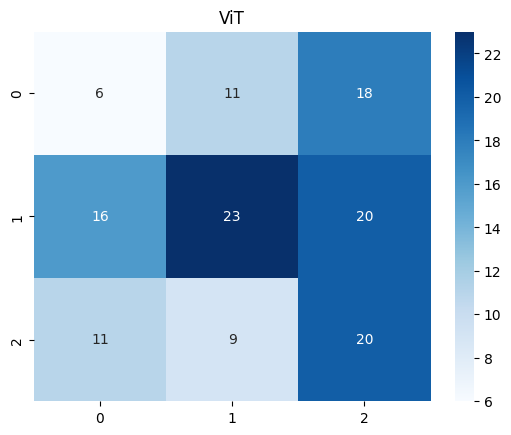


=== Final Test Performance: Swin ===
Accuracy: 0.4627
Precision: 0.4585  Recall: 0.4439  F1: 0.4443


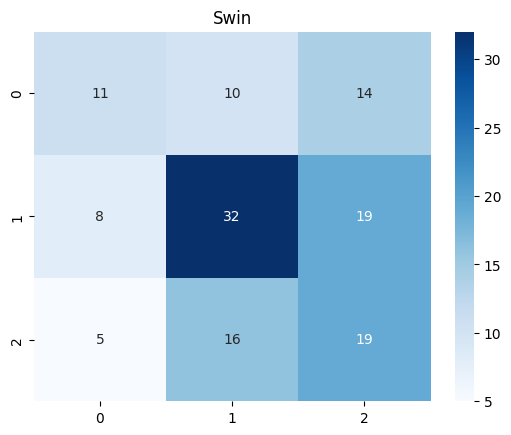

In [8]:

for name, (model, _) in results.items():
    print(f"\n=== Final Test Performance: {name} ===")
    loss, acc, preds, labels = evaluate(model, test_loader, criterion)
    cm = confusion_matrix(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {p:.4f}  Recall: {r:.4f}  F1: {f1:.4f}")

    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title(name)
    plt.show()


### 7. Evaluasi Akhir pada Test Set

Setelah pelatihan selesai, kinerja akhir setiap model dievaluasi pada *test set*, yaitu data yang belum pernah dilihat oleh model selama pelatihan atau validasi.
1.  **Evaluasi**: Fungsi `evaluate` dipanggil untuk mendapatkan akurasi, prediksi, dan label sebenarnya pada *test set*.
2.  **Metrik Tambahan**:
    *   **Confusion Matrix**: Dihitung menggunakan `sklearn.metrics.confusion_matrix` untuk melihat performa model pada setiap kelas secara spesifik.
    *   **Precision, Recall, F1-score**: Metrik ini memberikan gambaran yang lebih lengkap tentang kinerja model, terutama jika distribusi kelas tidak seimbang. `average='macro'` menghitung metrik untuk setiap kelas dan mengambil rata-ratanya.
3.  **Visualisasi**: *Confusion matrix* divisualisasikan sebagai *heatmap* menggunakan `seaborn` untuk interpretasi yang lebih mudah.

In [9]:

save_dir = "/content/drive/MyDrive/skin_vit_models"
os.makedirs(save_dir, exist_ok=True)

for name, (model, _) in results.items():
    torch.save(model.state_dict(), f"{save_dir}/{name}.pth")

print("Model Saved to Drive")


Model Saved to Drive


### 8. Menyimpan Model

Setelah dilatih dan dievaluasi, bobot (state dictionary) dari setiap model disimpan ke Google Drive. Ini memungkinkan kita untuk memuat kembali model di masa depan tanpa perlu melatih ulang.
1.  **Membuat Direktori**: Direktori `skin_vit_models` dibuat di Google Drive jika belum ada.
2.  **Menyimpan Bobot**: `torch.save(model.state_dict(), ...)` digunakan untuk menyimpan parameter yang telah dipelajari oleh model ke dalam file `.pth`.


## Dataset Description & Split
This section summarizes the number of images per class and per split (train/val/test) for the Oily, Dry and Normal Skin Types Dataset from Kaggle.


In [10]:

# Build a table of dataset distribution per class and split
class_names = train_ds.classes
train_counts = np.bincount(train_ds.targets)
val_counts   = np.bincount(val_ds.targets)
test_counts  = np.bincount(test_ds.targets)

dist_df = pd.DataFrame({
    'Class': class_names,
    'Train': train_counts,
    'Val':   val_counts,
    'Test':  test_counts
})
dist_df['Total'] = dist_df[['Train','Val','Test']].sum(axis=1)
dist_df.loc['Total'] = ['TOTAL', dist_df['Train'].sum(), dist_df['Val'].sum(), dist_df['Test'].sum(), dist_df['Total'].sum()]

print('Dataset distribution:')
display(dist_df)


Dataset distribution:


,Class,Train,Val,Test,Total
0,dry,652,71,35,758
1,normal,1104,111,59,1274
2,oily,1000,80,40,1120
Total,TOTAL,2756,262,134,3152



## Training Configuration (Hyperparameters)
This section summarizes the main hyperparameters used in training (image size, batch size, epochs, optimizer, learning rate, and loss function).


In [11]:

config = {
    'IMG_SIZE': IMG_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'Optimizer': 'Adam',
    'Learning Rate': 1e-4,
    'Loss': 'CrossEntropyLoss',
    'Augmentation (train)': 'Resize(IMG_SIZE), RandomHorizontalFlip, Normalize(0.5,0.5)',
    'Transform (test/val)': 'Resize(IMG_SIZE), Normalize(0.5,0.5)'
}

config_df = pd.DataFrame(list(config.items()), columns=['Component', 'Value'])
display(config_df)


,Component,Value
0,IMG_SIZE,224
1,BATCH_SIZE,32
2,EPOCHS,5
3,Optimizer,Adam
4,Learning Rate,0.0001
5,Loss,CrossEntropyLoss
6,Augmentation (train),"Resize(IMG_SIZE), RandomHorizontalFlip, Normal..."
7,Transform (test/val),"Resize(IMG_SIZE), Normalize(0.5,0.5)"



## Hardware and Software Specification
This cell prints basic information about the runtime environment (Python, PyTorch, device, and GPU if available).


In [12]:

print('Python version :', platform.python_version())
print('PyTorch version:', torch.__version__)
print('Device        :', device)

if torch.cuda.is_available():
    print('CUDA available:', torch.cuda.is_available())
    print('CUDA device   :', torch.cuda.get_device_name(0))
    print('CUDA capability:', torch.cuda.get_device_capability(0))
else:
    print('CUDA is not available in this runtime.')


Python version : 3.12.12
PyTorch version: 2.8.0+cu126
Device        : cuda
CUDA available: True
CUDA device   : Tesla T4
CUDA capability: (7, 5)



## Model Comparison Tables
This section produces three tables:
1. Number of parameters per model.
2. Evaluation metrics on the test set.
3. Approximate inference time on the test set.


In [13]:

from collections import defaultdict

summary_rows = []
cms = {}

for name, (model, _) in results.items():
    model.eval()
    # Parameter count
    n_params = sum(p.numel() for p in model.parameters())

    # Evaluate and measure inference time on the test set
    start = time.time()
    loss, acc, preds, labels = evaluate(model, test_loader, criterion)
    infer_time = time.time() - start

    cm = confusion_matrix(labels, preds)
    cms[name] = cm

    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    summary_rows.append({
        'Model': name,
        'Params': n_params,
        'Accuracy': acc,
        'Precision': p,
        'Recall': r,
        'F1': f1,
        'Inference Time (s)': infer_time
    })

summary_df = pd.DataFrame(summary_rows)

param_table   = summary_df[['Model', 'Params']]
metrics_table = summary_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]
time_table    = summary_df[['Model', 'Inference Time (s)']]

print('\nTable: Number of Parameters')
display(param_table)

print('\nTable: Evaluation Metrics (Test Set)')
display(metrics_table)

print('\nTable: Inference Time on Test Set')
display(time_table)



Table: Number of Parameters


,Model,Params
0,ViT,85800963
1,Swin,27521661



Table: Evaluation Metrics (Test Set)


,Model,Accuracy,Precision,Recall,F1
0,ViT,0.365672,0.353843,0.353753,0.345205
1,Swin,0.462687,0.458481,0.443886,0.444311



Table: Inference Time on Test Set


,Model,Inference Time (s)
0,ViT,2.360405
1,Swin,1.705860



## Learning Curves
This section visualizes the training and validation accuracy per epoch for each model.


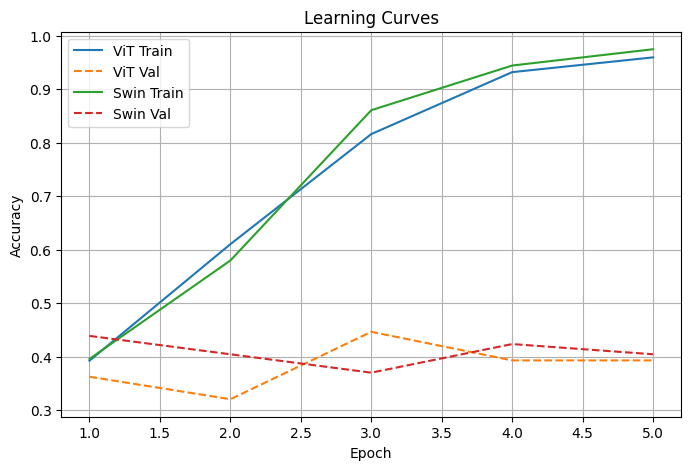

In [14]:

plt.figure(figsize=(8, 5))

for name, (_, history) in results.items():
    epochs = range(1, len(history['train']) + 1)
    plt.plot(epochs, history['train'], label=f'{name} Train')
    plt.plot(epochs, history['val'], linestyle='--', label=f'{name} Val')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()



## Confusion Matrices
Re-plot confusion matrices for each model using the stored predictions.


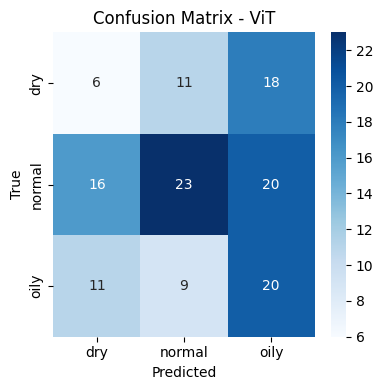

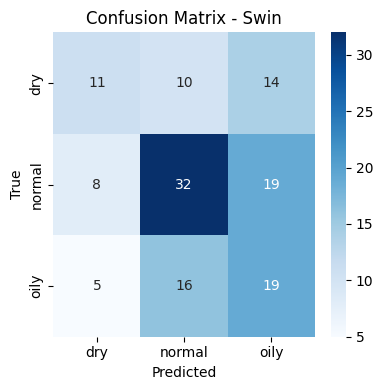

In [15]:

for name, cm in cms.items():
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_ds.classes,
                yticklabels=train_ds.classes)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()



## Example Predictions
This section visualizes a few test images together with the predicted and true labels for each model.


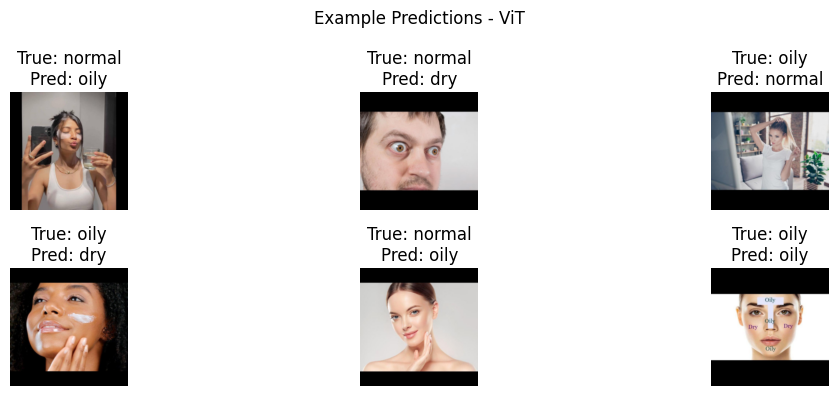

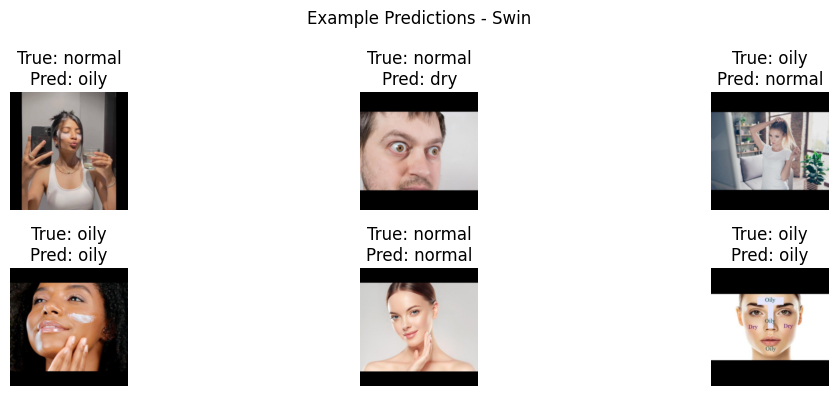

In [16]:

import random

# Take a small random subset of indices from the test dataset
indices = random.sample(range(len(test_ds)), k=min(6, len(test_ds)))
images = []
labels_true = []

for idx in indices:
    img, label = test_ds[idx]
    images.append(img)
    labels_true.append(label)

# Create a batch tensor
batch = torch.stack([img for img in images]).to(device)

for name, (model, _) in results.items():
    model.eval()
    with torch.no_grad():
        logits = model(batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

    plt.figure(figsize=(12, 4))
    for i, img in enumerate(images):
        plt.subplot(2, 3, i+1)
        # Undo normalization for display
        img_disp = img.clone() * 0.5 + 0.5
        plt.imshow(np.transpose(img_disp.numpy(), (1, 2, 0)))
        true_label = train_ds.classes[labels_true[i]]
        pred_label = train_ds.classes[preds[i]]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')

    plt.suptitle(f'Example Predictions - {name}')
    plt.tight_layout()
    plt.show()



## Automatic Analysis Summary
This cell gives a brief, data-driven comparison between the models based on accuracy, number of parameters, and inference time.


In [17]:

# Identify best models according to different criteria
best_acc = summary_df.sort_values('Accuracy', ascending=False).iloc[0]
best_f1  = summary_df.sort_values('F1', ascending=False).iloc[0]
smallest_model = summary_df.sort_values('Params', ascending=True).iloc[0]
fastest_model  = summary_df.sort_values('Inference Time (s)', ascending=True).iloc[0]

print('Best accuracy model   :', best_acc['Model'], 'with Accuracy =', best_acc['Accuracy'])
print('Best F1-score model   :', best_f1['Model'],  'with F1 =', best_f1['F1'])
print('Smallest model (params):', smallest_model['Model'], 'with Params =', smallest_model['Params'])
print('Fastest inference model:', fastest_model['Model'],  'with Time (s) =', fastest_model['Inference Time (s)'])

print('\nInterpretation:')
print('- Model with the highest accuracy/F1 is generally the most accurate on this dataset.')
print('- The smallest model is more efficient (fewer parameters) and may generalize better on limited hardware.')
print('- The fastest model is preferable for real-time or resource-constrained deployment.')
print('- Trade-offs appear when a model has higher accuracy but also significantly more parameters or slower inference.')


Best accuracy model   : Swin with Accuracy = 0.4626865671641791
Best F1-score model   : Swin with F1 = 0.44431112706720666
Smallest model (params): Swin with Params = 27521661
Fastest inference model: Swin with Time (s) = 1.705859661102295

Interpretation:
- Model with the highest accuracy/F1 is generally the most accurate on this dataset.
- The smallest model is more efficient (fewer parameters) and may generalize better on limited hardware.
- The fastest model is preferable for real-time or resource-constrained deployment.
- Trade-offs appear when a model has higher accuracy but also significantly more parameters or slower inference.
